In [1]:
from sklearn.datasets import fetch_openml

## Load mnist data and let observe it for a bit

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [4]:
print(f'input shape {mnist["data"].shape}')
print(f'label shape {mnist["target"].shape}')

print(f'type input : {type(mnist["data"][0])}')
print(f'type input : {type(mnist["target"][0])}')

# convert mnist target to int
mnist_label = mnist['target'].astype('int')

input shape (70000, 784)
label shape (70000,)
type input : <class 'numpy.ndarray'>
type input : <class 'str'>


In [5]:
X_train, X_test = mnist['data'][:60000], mnist['data'][60000:]
y_train, y_test = mnist_label[:60000], mnist_label[60000:]

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import random

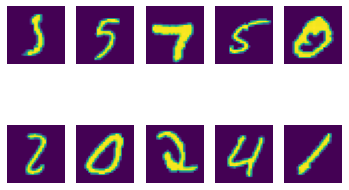

In [7]:
# explore some input

num_show = 10

for i in range(10):
    idx = random.randint(0, mnist['data'].shape[1]-1)
    plt.subplot(2, 5, i+1)
    img = mnist['data'][idx].reshape(28, 28)
    plt.imshow(img)
    plt.axis('Off')

## Begin using ml to predict the mnist dataset
* Note that at the first step we just at least need to classify only 2 class, 9 or not 9  
* Then, comparing the performance index using accuracy, precision, recall, and f1 score  
* Try plotting recall/precision versus threshold curve to obeserve the impact of choosing threshold value  
* Finally, choosing the appropriate threshold such that the model have precision at least 90% at the best possible recall


In [8]:
from sklearn.linear_model import SGDClassifier

# we will use sgdclassifier which is SVM by default
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

import joblib
import pickle
import time
import os

os.makedirs('saved_model/mnist-classification', exist_ok=True)

# test dump time
# st = time.time()
# joblib.dump(sgd_clf, 'saved_model/multiclasssvm-model-joblib')
# print(f'elapsed time {time.time() - st }')


st = time.time()
with open('saved_model/multiclass-svm-model', 'wb') as f:

    pickle.dump(sgd_clf, f)

print(f'elapsed time {time.time() - st }')

In [45]:
import time
import pickle
import numpy as np
import os
# test load time
# st = time.time()
# load_moedl = joblib.load('saved_model/svm-model-joblib')
# print(f'elapsed time {time.time() - st }')
SAVED_MODEL_ROOT = './saved_model/mnist-classification'

st = time.time()
with open('saved_model/mnist-classification/svm-model-pickle', 'rb') as f:
    sgd_clf = pickle.load(f)

print(f'elapsed time {time.time() - st }')

elapsed time 0.001390218734741211


In [12]:
print(sgd_clf.score(X_train, y_train))
print(sgd_clf.score(X_test[0], y_test))

0.8608166666666667
0.846


In [18]:
sgd_clf.coef_

array([-22987.33265649, -48770.87111544,  -9344.16637963,  -1918.6059087 ,
       -34380.59181952,  -8339.20909417, -29777.36893014,  10668.92884763,
        -3486.80968706,  -4655.76574083])

In [23]:
sgd_clf.predict(np.expand_dims(X_test[0], axis=0))

array([7])

## Train only on 9 and not 9 classification

In [28]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

print(y_train_9.any())

True


## train on the model that classify 9 and not 9 prediction
sgd_clf_nine = SGDClassifier()
sgd_clf_nine.fit(X_train, y_train_9)

## Save the model

model_name = 'svm-pred-9'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open('./saved_model/mnist-classification/svm-pred-9', 'wb') as f:
    pickle.dump(sgd_clf_nine, f)

In [51]:
## load the model
model_name = 'svm-pred-9'
model_path = os.path.join(SAVED_MODEL_ROOT , model_name)

with open(model_path, 'rb') as f:
    sgd_clf_9 = pickle.load(f)

In [49]:
## use another metrics to evaluate performance
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [52]:
## but first, we will predict the train set using cross validate
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [53]:
## equivalent to cross_validation_score

skf = StratifiedKFold(n_splits = 3)

for train_idx, test_idx in skf.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf_9)
    clone_clf.fit(X_train[train_idx], y_train_9[train_idx])
    
    test_pred = clone_clf.predict(X_train[test_idx])
    precision = precision_score(y_train_9[test_idx], test_pred)
    recall = recall_score(y_train_9[test_idx], test_pred)
    
    print(f'precision {precision} recall {recall}')

precision 0.7568922305764411 recall 0.6091780131114473
precision 0.8745762711864407 recall 0.26021180030257185
precision 0.6565373850459816 recall 0.8280383257690368


In [55]:
## out of the box cv_score
from sklearn.model_selection import cross_val_score

history = cross_val_score(sgd_clf_9, X_train, y_train_9)

In [63]:
## create custom estimator that always classify as 9
from sklearn.base import BaseEstimator

class NeverNine(BaseEstimator):
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        num_sample = X.shape[0]
        
        return np.zeros((num_sample,))

In [67]:
neverNine = NeverNine()

history_neverNine = cross_val_score(neverNine, X_train, y_train_9, cv = 3, scoring = 'accuracy')

In [69]:
print(history_alwaysNine)

[0.8993  0.8999  0.90335]


**Note that, the model that only predict not 9 have the accuracy of 90%**  
So, it is clear that this model doesn't help at all if we only use the accuracy and performance index  
Next step, we will plotting the precision and recall versus threshold value to observe its characteristics.

In [102]:
from sklearn.model_selection import cross_val_predict

y_score_cv = cross_val_predict(sgd_clf_9, X_train, y_train_9, method = 'decision_function')
# y_score_cv = y_train_cv

In [75]:
from sklearn.metrics import precision_recall_curve

In [77]:
precision, recall, thresholds = precision_recall_curve(y_train_9, y_score_cv)

(59177,)
(59178,)
(59178,)


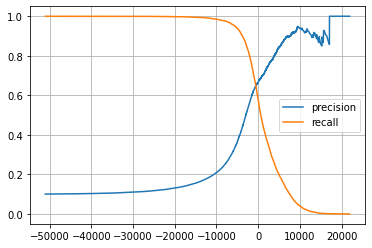

In [82]:
print(thresholds.shape)
print(precision.shape)
print(recall.shape)
plt.plot(thresholds, precision[:-1])
plt.plot(thresholds, recall[:-1])
plt.grid('On')
plt.legend(['precision', 'recall'])

From the above figure, we can cleary see the trade off between precision and recall.  
Precision will be higher if the model predict as positive when it is strongly confident.  
But note that if the model is strongly confident, it may let the positive sample that it doesn't have much confident pass through.  
**Next step, we will choose an appropriate threshold of the model such that it has precisions at least 90%**

In [93]:
selected_thres = thresholds[np.argmax(precision >= 0.9)]

In [94]:
print(selected_thres)

7488.9512656140305


In [103]:
desired_p = precision_score(y_train_9, y_score_cv >= selected_thres)
desired_r = recall_score(y_train_9, y_score_cv >= selected_thres)

print(f'precision {desired_p}')
print(f'recall {desired_r}')

precision 0.9
recall 0.10287443267776097


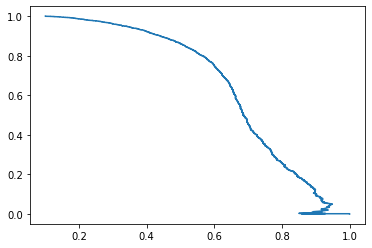

In [98]:
# plotting precision vs recall
plt.plot(precision, recall)

In [104]:
# confusion matrix
confusion_matrix(y_train_9, y_score_cv >= selected_thres)

array([[53983,    68],
       [ 5337,   612]])

## Now we will explore on ROC curve and RandomForestClassifier

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [154]:
def plot_roc(y_train_9, y_score):

    fpr, tpr, thresholds = roc_curve(y_train_9, y_score)

    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, alpha = 0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    auc_score = roc_auc_score(y_train_9, y_score)
    plt.xlabel(f'AUC score {auc_score:.5f}')

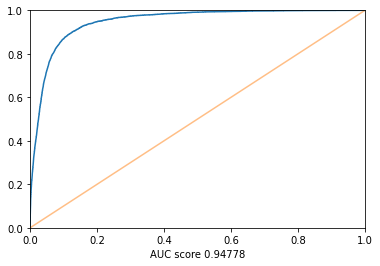

In [155]:
plot_roc(y_train_9, y_score_cv)

## We will try on Randomforest and adaboost
random_forest = RandomForestClassifier()
ada_tree = AdaBoostClassifier()

pred_prob_random_forest = cross_val_predict(random_forest, X_train, y_train_9, cv = 3, method='predict_proba')
pred_prob_ada = cross_val_predict(ada_tree, X_train, y_train_9, cv = 3, method='predict_proba')

In [156]:
# save random forest pred_proba and its model
pack_name = 'random-forest-and-pred-proba'
pack_path = os.path.join(SAVED_MODEL_ROOT, pack_name)

with open(pack_path, 'wb') as f:
    serialize_obj = pickle.dumps((random_forest, pred_prob_random_forest))
    f.write(serialize_obj)

# save adaboost
pack_name = 'adaboost-and-pred-proba'
pack_path = os.path.join(SAVED_MODEL_ROOT, pack_name)

with open(pack_path, 'wb') as f:
    serialize_obj = pickle.dumps((ada_tree, pred_prob_ada))
    f.write(serialize_obj)

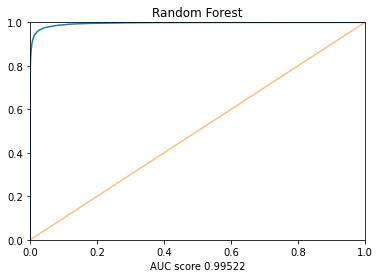

0.981324945940633
0.8391326273323247


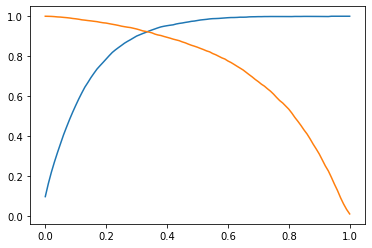

In [157]:
plot_roc(y_train_9, 1-pred_prob_random_forest[:, 0])
plt.title('Random Forest')
plt.show()

precision_sc = precision_score(y_train_9, np.argmax(pred_prob_random_forest, axis = 1))
recall_sc = recall_score(y_train_9, np.argmax(pred_prob_random_forest, axis = 1))
print(f'{precision_sc}')
print(f'{recall_sc}')

precisions, recalls, thresholds = precision_recall_curve(y_train_9, 1-pred_prob_random_forest[:, 0])
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])

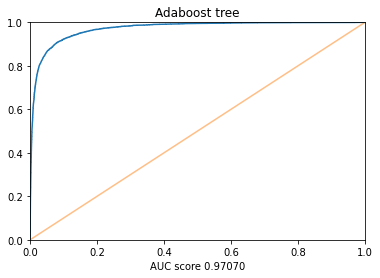

0.8053655023406554
0.7518910741301059


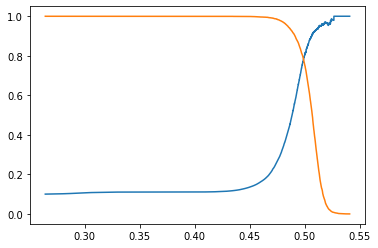

In [158]:
plot_roc(y_train_9, 1-pred_prob_ada[:, 0])
plt.title('Adaboost tree')
plt.show()

precision_sc = precision_score(y_train_9, np.argmax(pred_prob_ada, axis = 1))
recall_sc = recall_score(y_train_9, np.argmax(pred_prob_ada, axis = 1))
print(f'{precision_sc}')
print(f'{recall_sc}')

precisions, recalls, thresholds = precision_recall_curve(y_train_9, 1-pred_prob_ada[:, 0])
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])

## It's time to play with multiclassification!

In [174]:
# one vs one
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [161]:
# SVC using one vs rest classifier

model_name = 'multiclass-svm-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'rb') as f:
    sgd_clf = pickle.load(f)

# train svc model using OvO
svc_clf = SVC()
svc_clf.fit(X_train, y_train)

#save svc model
model_name = 'multiclass-svc-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'wb') as f:
    serial = pickle.dumps(svc_clf)
    f.write(serial)

In [168]:
# load the model
model_name = 'multiclass-svc-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'rb') as f:
    svc_clf = pickle.load(f)

svc_clf.score(X_test, y_test)

In [171]:
svc_clf.dual_coef_.shape

(9, 12336)

In [239]:
## normalize the image
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [240]:
#train random forest on normalized model
multi_forest_clf_norm = RandomForestClassifier()
multi_forest_clf_norm.fit(X_train_scale, y_train)

RandomForestClassifier()

In [241]:
#save
model_name = 'multiclass-randomforest-norm-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'wb') as f:
    serial = pickle.dumps(multi_forest_clf_norm)
    f.write(serial)

In [233]:
#load model
model_name = 'multiclass-randomforest-norm-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'rb') as f:
    multi_forest_clf_norm = pickle.load(f)

In [242]:
#print random forest score
print(multi_forest_clf_norm.score(X_test_scale, y_test))
print(multi_forest_clf_norm.score(X_train_scale, y_train))

0.9697
1.0


multi_forest_clf = RandomForestClassifier()
multi_forest_clf.fit(X_train, y_train)

#save svc model
model_name = 'multiclass-randomforest-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'wb') as f:
    serial = pickle.dumps(multi_forest_clf)
    f.write(serial)

In [173]:
multi_forest_clf.score(X_test, y_test)

0.9705

In [178]:
multi_forest_clf.score(X_train, y_train)

1.0

In [186]:
some_idx = random.randint(0, 9999)

pred_class = multi_forest_clf.classes_[multi_forest_clf.predict(X_test[some_idx].reshape(1, -1))]
true_class = y_test[some_idx]

print(f'pred : {pred_class[0]} true : {true_class}')

pred : 5 true : 5


In [175]:
# load the model
model_name = 'multiclass-randomforest-model'
model_path = os.path.join(SAVED_MODEL_ROOT, model_name)

with open(model_path, 'rb') as f:
    multi_forest_clf = pickle.load(f)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn.score(X_test, y_test)

In [223]:
# observe confusion matrix on test set, normally it should be on train set with cross validation
# but the training takes to long so I just use test set instead

multi_class_confmat = confusion_matrix(y_test, multi_forest_clf.classes_[multi_forest_clf.predict(X_test)])
print(multi_class_confmat)

[[ 972    1    2    0    0    1    1    1    2    0]
 [   0 1125    3    1    0    2    2    0    2    0]
 [   5    1  999    3    3    0    4   10    7    0]
 [   0    0   10  976    0    4    0    8    8    4]
 [   1    0    2    0  952    0    4    1    3   19]
 [   2    0    1   12    2  860    5    2    5    3]
 [   6    3    1    0    3    2  941    0    2    0]
 [   2    2   21    1    1    0    0  986    4   11]
 [   5    1    4    5    5    6    5    4  932    7]
 [   5    5    2   11   10    3    1    4    6  962]]


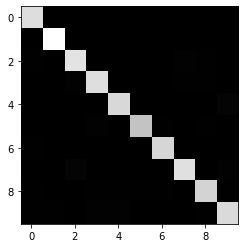

In [218]:
plt.imshow(multi_class_confmat, cmap='gray')

In [219]:
import copy

# normalized confusion matrix such that we can see the error more clear
multi_class_confmat_norm = np.copy(multi_class_confmat)
multi_class_confmat_norm = multi_class_confmat_norm/np.sum(multi_class_confmat, axis = 1)
np.fill_diagonal(multi_class_confmat_norm, 0)

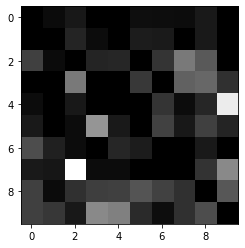

In [222]:
plt.imshow(multi_class_confmat_norm, cmap='gray')

## Question 2 data augmentation using shifting image

In [259]:
def shift_image(shift_pos: str, shift_dist: int, img):
    img_copy = np.copy(img)
    img_mat = img_copy.reshape(28, 28)
    
    if shift_pos == 'up':
        img_mat[:-shift_dist, :] = img_mat[shift_dist:, :]
        img_mat[-shift_dist:, :] = np.zeros((shift_dist, 28))
    
    if shift_pos == 'left':
        img_mat[:, :-shift_dist] = img_mat[:, shift_dist:]
        img_mat[:, -shift_dist:] = np.zeros((28, shift_dist))
        
    return img_mat.reshape(1, -1)

In [292]:
def populate_X(X, y, num_pop, seed):
    np.random.seed(seed)
    random.seed(seed)
    
    X_pop = np.zeros((num_pop, 28**2))
    y_pop = np.zeros((num_pop, ))
    
    for i in range(num_pop):
        pos = random.choice(['up','left'])
        dist = random.randint(1,3)
        idx = np.random.randint(0, 59999)
        
        X_pop[i] = shift_image(pos, dist, X[idx])
        y_pop[i] = y[idx]
        
    return X_pop, y_pop

In [301]:
X_pop, y_pop = populate_X(X_train, y_train, 30000, 42)
X_train_pop = np.append(X_train, X_pop, axis = 0)
y_train_pop = np.append(y_train, y_pop, axis = 0)
print(X_train_pop.shape)
print(y_train_pop.shape)

(90000, 784)
(90000,)


Text(0.5, 1.0, '8.0')

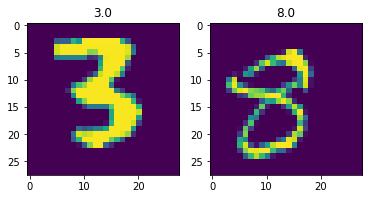

In [302]:
plt.subplot(1,2,1)
plt.imshow(X_pop[455].reshape(28,28))
plt.title(y_pop[455])
plt.subplot(1,2,2)
plt.imshow(X_pop[234].reshape(28,28))
plt.title(y_pop[234])

In [303]:
# train again on new data with augmentation
## normalize the image
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pop_scale = scaler.fit_transform(X_train_pop)

#train random forest on normalized model
multi_forest_clf_norm = RandomForestClassifier()
multi_forest_clf_norm.fit(X_train_pop_scale, y_train_pop)

RandomForestClassifier()

In [304]:
X_test_scale = scaler.transform(X_test)

multi_forest_clf_norm.score(X_test_scale, y_test)

0.9711

In [305]:
## We can see that, the more number of data augmentation, the more accuracy it becomes!